Filtering users with fewer than 50 ratings...
Number of users after filtering: 85307
Filtering movies rated by fewer than 20 users...
Number of movies after filtering: 13063

Running with num_hashes=100, num_bands=10, rows_per_band=10
Time taken: 499.31 seconds


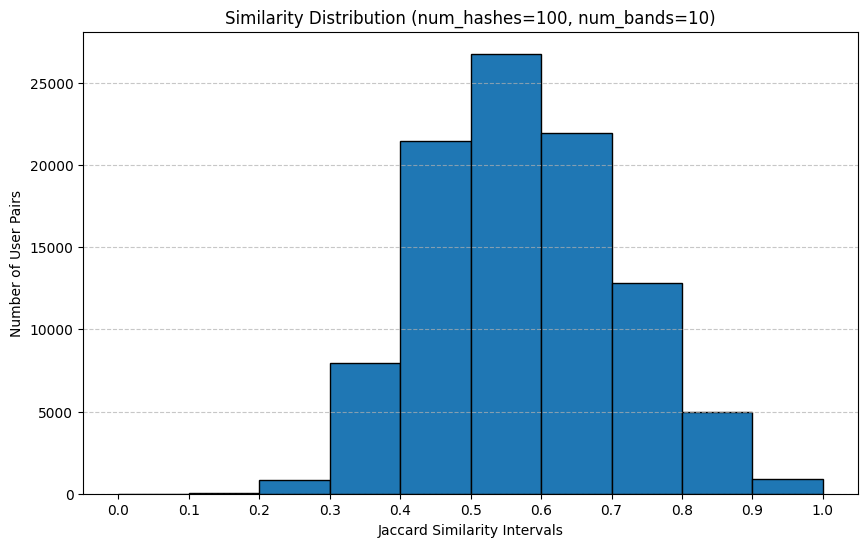


Running with num_hashes=100, num_bands=20, rows_per_band=5
Time taken: 603.53 seconds


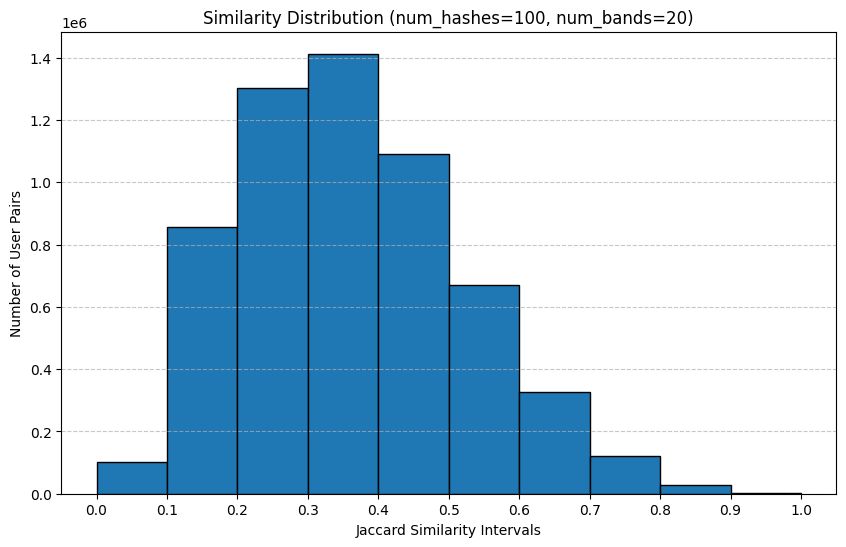


Running with num_hashes=100, num_bands=30, rows_per_band=3
Time taken: 4521.48 seconds


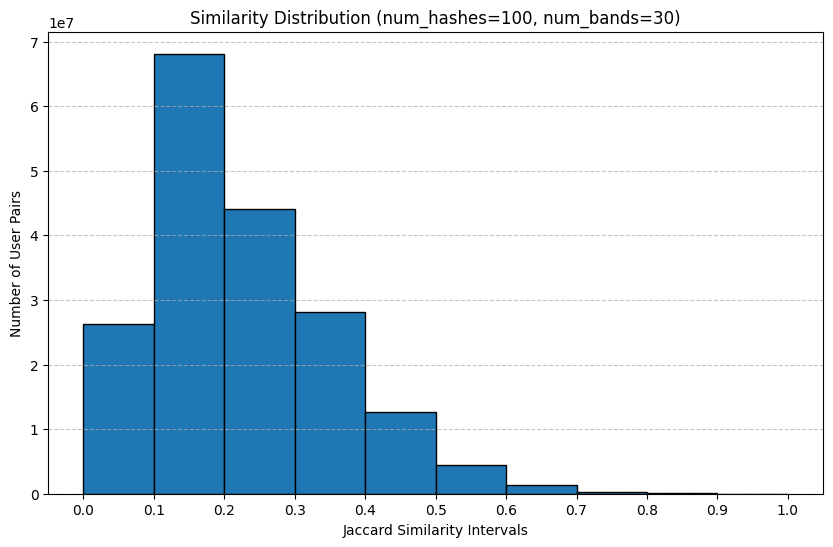


Running with num_hashes=200, num_bands=10, rows_per_band=20
Time taken: 993.48 seconds


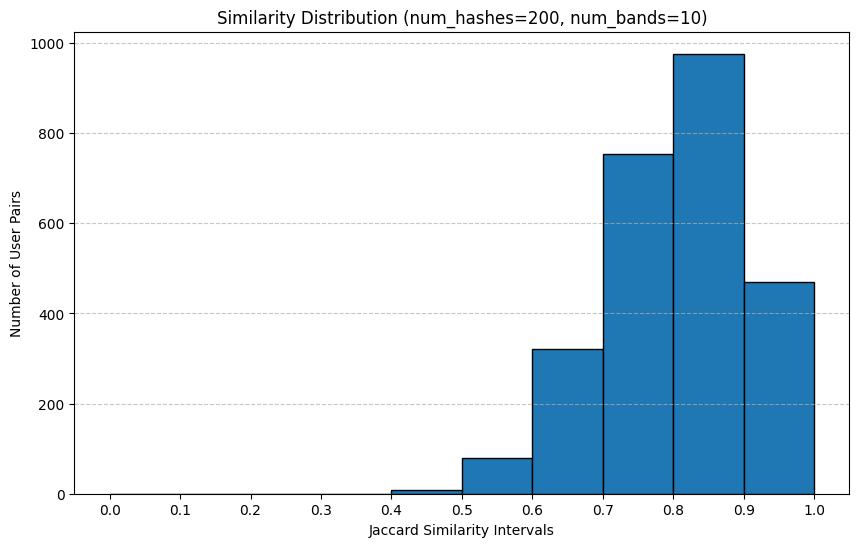


Running with num_hashes=200, num_bands=20, rows_per_band=10
Time taken: 1044.82 seconds


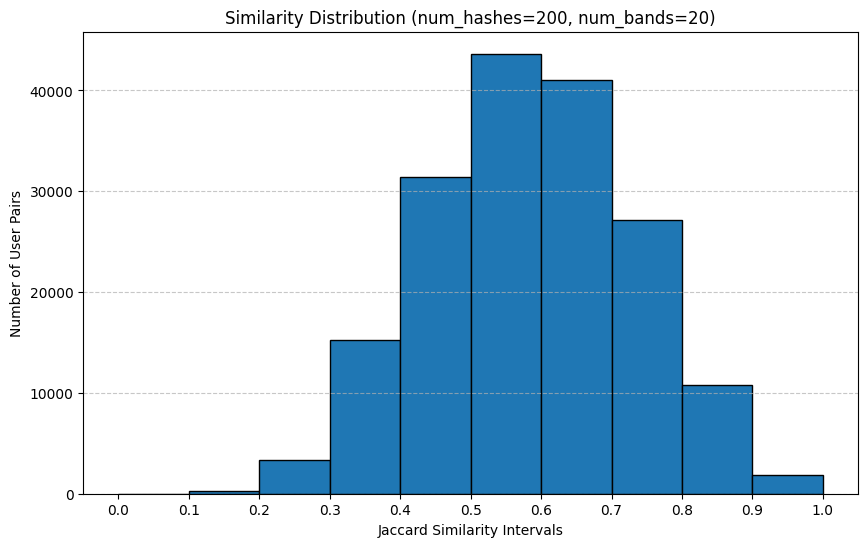


Running with num_hashes=200, num_bands=30, rows_per_band=6
Time taken: 1092.12 seconds


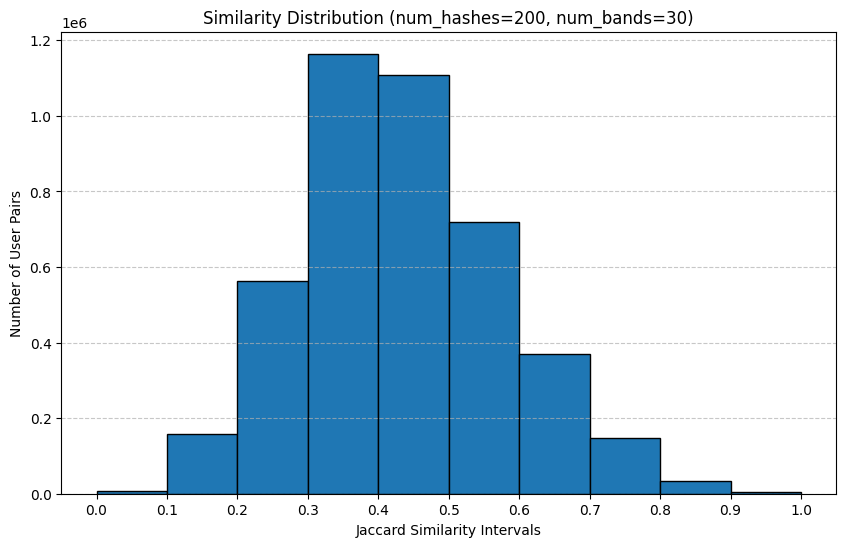


Running with num_hashes=300, num_bands=10, rows_per_band=30
Time taken: 1519.69 seconds


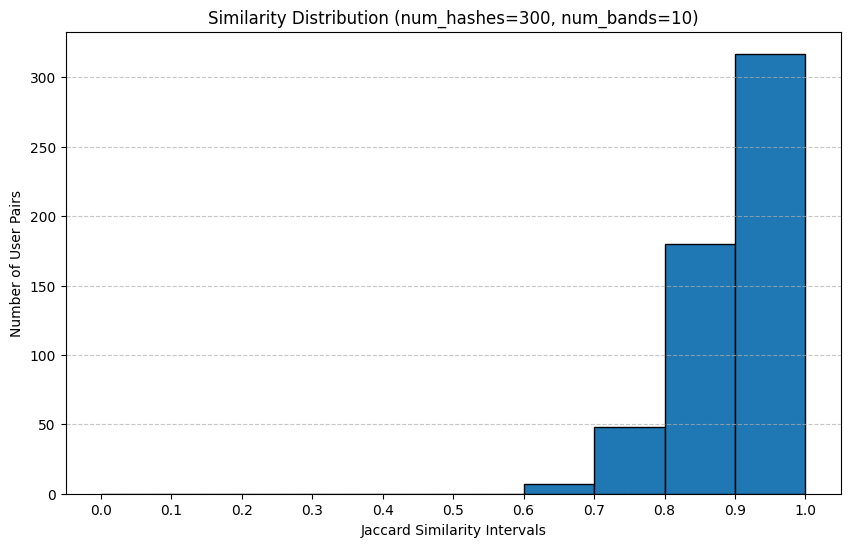


Running with num_hashes=300, num_bands=20, rows_per_band=15
Time taken: 1592.51 seconds


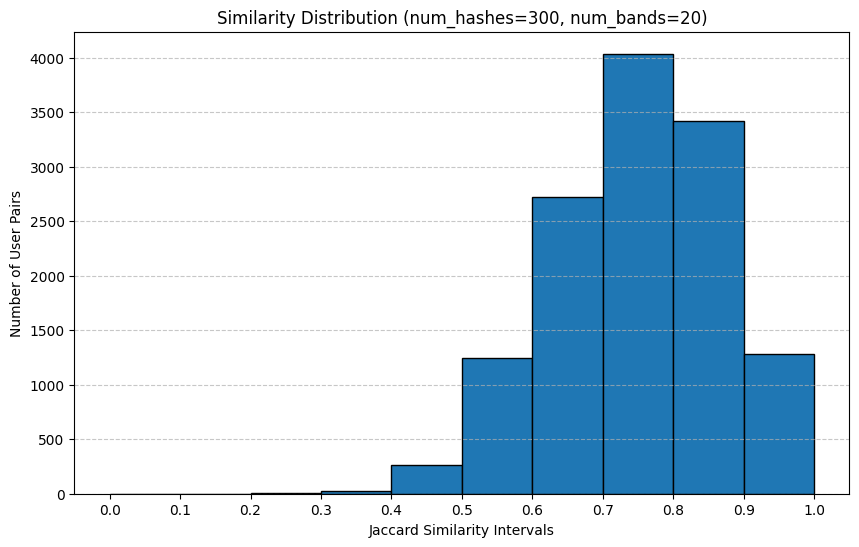


Running with num_hashes=300, num_bands=30, rows_per_band=10
Time taken: 1595.14 seconds


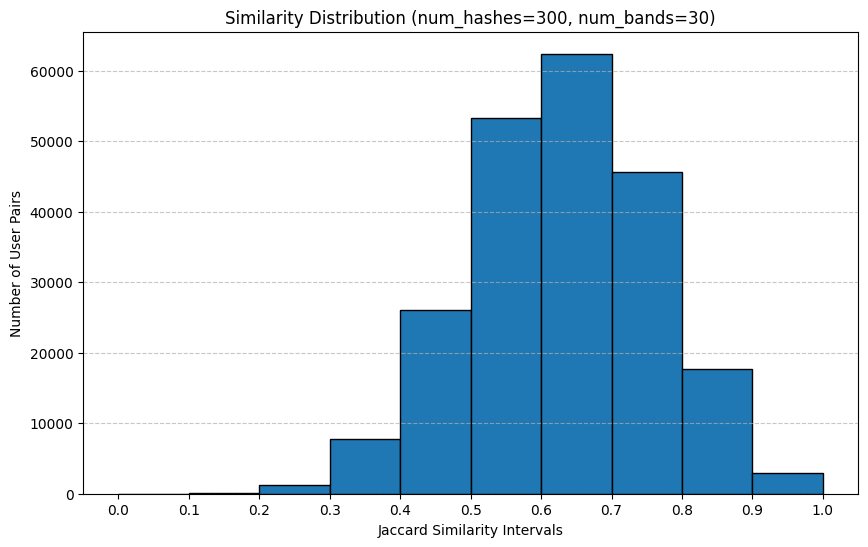


Summary of tested configurations:
Configuration: num_hashes=100, num_bands=10, rows_per_band=10
  Average similarity: 0.577
  Average number of users per bucket: 3.47
  Average number of pairs compared per bucket: 21.21
  Percentage of unique users: 7.83%
  Non-empty buckets: 4605
  Pairs with Jaccard similarity >= 0.2: 97636
  Pairs with Jaccard similarity >= 0.4: 88846
  Pairs with Jaccard similarity >= 0.6: 41128
  Pairs with Jaccard similarity >= 0.8: 5894
  Time taken: 499.31 seconds

Configuration: num_hashes=100, num_bands=20, rows_per_band=5
  Average similarity: 0.362
  Average number of users per bucket: 4.20
  Average number of pairs compared per bucket: 57.30
  Percentage of unique users: 82.99%
  Non-empty buckets: 103195
  Pairs with Jaccard similarity >= 0.2: 4954172
  Pairs with Jaccard similarity >= 0.4: 2237040
  Pairs with Jaccard similarity >= 0.6: 487672
  Pairs with Jaccard similarity >= 0.8: 29160
  Time taken: 603.53 seconds

Configuration: num_hashes=100, num_

In [ ]:
import pandas as pd
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import time

random.seed(42)
np.random.seed(42)

ratings = pd.read_csv("rating.csv")
movies = pd.read_csv("movie.csv")

movie_details = movies.set_index('movieId').to_dict('index')

min_user_ratings = 50
min_movie_ratings = 20

print("Filtering users with fewer than 50 ratings...")
user_counts = ratings['userId'].value_counts()
filtered_users = user_counts[user_counts >= min_user_ratings].index
ratings = ratings[ratings['userId'].isin(filtered_users)]
print(f"Number of users after filtering: {len(filtered_users)}")

print("Filtering movies rated by fewer than 20 users...")
movie_counts = ratings['movieId'].value_counts()
filtered_movies = movie_counts[movie_counts >= min_movie_ratings].index
ratings = ratings[ratings['movieId'].isin(filtered_movies)]
print(f"Number of movies after filtering: {len(filtered_movies)}")

user_movie_sets = ratings.groupby('userId')['movieId'].apply(set).to_dict()

def generate_hash_functions(num_hashes, max_val):
    hash_functions = []
    for _ in range(num_hashes):
        a = random.randint(1, max_val)
        b = random.randint(0, max_val)
        hash_functions.append(lambda x, a=a, b=b, p=max_val+1: (a * x + b) % p)
    return hash_functions

def compute_minhash_signatures(user_sets, hash_functions):
    num_users = len(user_sets)
    signature_matrix = np.full((len(hash_functions), num_users), np.inf)
    user_list = list(user_sets.keys())
    for user_idx, user in enumerate(user_list):
        for movie in user_sets[user]:
            for hash_idx, hash_func in enumerate(hash_functions):
                signature_matrix[hash_idx, user_idx] = min(signature_matrix[hash_idx, user_idx], hash_func(movie))
    return signature_matrix, user_list

def jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2) if len(set1 | set2) > 0 else 0

def create_lsh_buckets(signature_matrix, num_bands, rows_per_band):
    buckets = defaultdict(list)
    for band in range(num_bands):
        start_row = band * rows_per_band
        end_row = start_row + rows_per_band
        for user_idx in range(signature_matrix.shape[1]):
            band_signature = tuple(signature_matrix[start_row:end_row, user_idx])
            buckets[(band, band_signature)].append(user_idx)
    return buckets

hashes_list = [100, 200, 300]  
bands_list = [10, 20, 30]  
thresholds = [0.2, 0.4, 0.6, 0.8] 

max_movie_id = max(max(user_set) for user_set in user_movie_sets.values())

results = []
for num_hashes in hashes_list:
    for num_bands in bands_list:
        rows_per_band = num_hashes // num_bands
        if rows_per_band == 0:
            continue  
        
        print(f"\nRunning with num_hashes={num_hashes}, num_bands={num_bands}, rows_per_band={rows_per_band}")
        
        start_time = time.time()
        
        hash_functions = generate_hash_functions(num_hashes, max_movie_id)
        
        signature_matrix, user_list = compute_minhash_signatures(user_movie_sets, hash_functions)
        
        buckets = create_lsh_buckets(signature_matrix, num_bands, rows_per_band)
        
        non_empty_buckets = {key: users for key, users in buckets.items() if len(users) > 1}
        
        total_users_in_buckets = sum(len(users) for users in non_empty_buckets.values())
        unique_users_in_buckets = len(set(user for users in non_empty_buckets.values() for user in users))
        total_pairs = sum(len(users) * (len(users) - 1) // 2 for users in non_empty_buckets.values())
        total_buckets = len(non_empty_buckets)
        avg_users_per_bucket = total_users_in_buckets / total_buckets if total_buckets > 0 else 0
        avg_pairs_per_bucket = total_pairs / total_buckets if total_buckets > 0 else 0
        unique_user_percentage = (unique_users_in_buckets / len(user_list)) * 100

        similarities = []
        for bucket_users in non_empty_buckets.values():
            for i in range(len(bucket_users)):
                for j in range(i + 1, len(bucket_users)):
                    user1_idx = bucket_users[i]
                    user2_idx = bucket_users[j]
                    user1 = user_list[user1_idx]
                    user2 = user_list[user2_idx]
                    sim = jaccard_similarity(user_movie_sets[user1], user_movie_sets[user2])
                    similarities.append(sim)

        avg_similarity = np.mean(similarities) if similarities else 0
        
        threshold_counts = {threshold: sum(1 for sim in similarities if sim >= threshold) for threshold in thresholds}
        
        elapsed_time = time.time() - start_time
        print(f"Time taken: {elapsed_time:.2f} seconds")
        
        results.append({
            "num_hashes": num_hashes,
            "num_bands": num_bands,
            "rows_per_band": rows_per_band,
            "avg_similarity": avg_similarity,
            "avg_users_per_bucket": avg_users_per_bucket,
            "avg_pairs_per_bucket": avg_pairs_per_bucket,
            "unique_user_percentage": unique_user_percentage,
            "elapsed_time": elapsed_time,
            "non_empty_buckets": total_buckets,
            "similarities": similarities,
            "threshold_counts": threshold_counts
        })

        bins = np.arange(0, 1.1, 0.1)
        hist, bin_edges = np.histogram(similarities, bins=bins)

        plt.figure(figsize=(10, 6))
        plt.bar(bin_edges[:-1], hist, width=0.1, edgecolor="black", align="edge")
        plt.xlabel("Jaccard Similarity Intervals")
        plt.ylabel("Number of User Pairs")
        plt.title(f"Similarity Distribution (num_hashes={num_hashes}, num_bands={num_bands})")
        plt.xticks(bins)
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.show()

print("\nSummary of tested configurations:")
for result in results:
    print(f"Configuration: num_hashes={result['num_hashes']}, num_bands={result['num_bands']}, rows_per_band={result['rows_per_band']}")
    print(f"  Average similarity: {result['avg_similarity']:.3f}")
    print(f"  Average number of users per bucket: {result['avg_users_per_bucket']:.2f}")
    print(f"  Average number of pairs compared per bucket: {result['avg_pairs_per_bucket']:.2f}")
    print(f"  Percentage of unique users: {result['unique_user_percentage']:.2f}%")
    print(f"  Non-empty buckets: {result['non_empty_buckets']}")
    for threshold, count in result["threshold_counts"].items():
        print(f"  Pairs with Jaccard similarity >= {threshold}: {count}")
    print(f"  Time taken: {result['elapsed_time']:.2f} seconds")
    print()

Filtraggio utenti con meno di 50 valutazioni...
Numero di utenti dopo il filtraggio: 85307
Filtraggio film valutati da meno di 20 utenti...
Numero di film dopo il filtraggio: 13063
Calcolo delle MinHash Signatures...
MinHash Signatures calcolate per 85307 utenti.
Numero di bande: 20, righe per banda: 5
Numero totale di buckets: 1405329
Buckets con più di un utente: 97421

Distribuzione delle similarità Jaccard:
Fascia 0.0 - 0.1: 35128 coppie
Fascia 0.1 - 0.2: 491157 coppie
Fascia 0.2 - 0.3: 1094830 coppie
Fascia 0.3 - 0.4: 1645193 coppie
Fascia 0.4 - 0.5: 1339354 coppie
Fascia 0.5 - 0.6: 737564 coppie
Fascia 0.6 - 0.7: 316127 coppie
Fascia 0.7 - 0.8: 109775 coppie
Fascia 0.8 - 0.9: 24870 coppie
Fascia 0.9 - 1.0: 2598 coppie


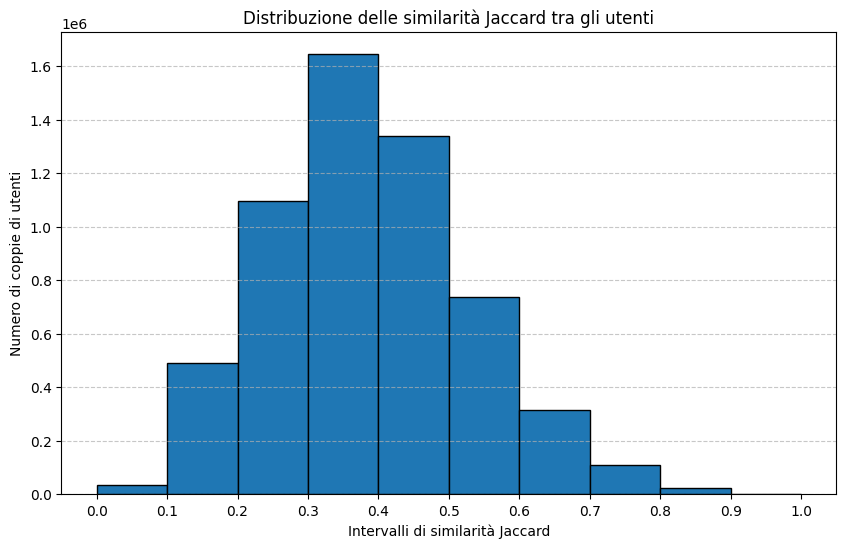

In [ ]:
import pandas as pd
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)

ratings = pd.read_csv("rating.csv")
movies = pd.read_csv("movie.csv")

movie_details = movies.set_index('movieId').to_dict('index')

min_user_ratings = 50
min_movie_ratings = 20

print("Filtraggio utenti con meno di 50 valutazioni...")
user_counts = ratings['userId'].value_counts()
filtered_users = user_counts[user_counts >= min_user_ratings].index
ratings = ratings[ratings['userId'].isin(filtered_users)]
print(f"Numero di utenti dopo il filtraggio: {len(filtered_users)}")

print("Filtraggio film valutati da meno di 20 utenti...")
movie_counts = ratings['movieId'].value_counts()
filtered_movies = movie_counts[movie_counts >= min_movie_ratings].index
ratings = ratings[ratings['movieId'].isin(filtered_movies)]
print(f"Numero di film dopo il filtraggio: {len(filtered_movies)}")

user_movie_sets = ratings.groupby('userId')['movieId'].apply(set).to_dict()

def generate_hash_functions(num_hashes, max_val):
    hash_functions = []
    for _ in range(num_hashes):
        a = random.randint(1, max_val)
        b = random.randint(0, max_val)
        hash_functions.append(lambda x, a=a, b=b, p=max_val+1: (a * x + b) % p)
    return hash_functions

def compute_minhash_signatures(user_sets, hash_functions):
    num_users = len(user_sets)
    signature_matrix = np.full((len(hash_functions), num_users), np.inf)
    user_list = list(user_sets.keys())
    for user_idx, user in enumerate(user_list):
        for movie in user_sets[user]:
            for hash_idx, hash_func in enumerate(hash_functions):
                signature_matrix[hash_idx, user_idx] = min(signature_matrix[hash_idx, user_idx], hash_func(movie))
    return signature_matrix, user_list

def jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2) if len(set1 | set2) > 0 else 0

def create_lsh_buckets(signature_matrix, num_bands, rows_per_band):
    buckets = defaultdict(list)
    for band in range(num_bands):
        start_row = band * rows_per_band
        end_row = start_row + rows_per_band
        for user_idx in range(signature_matrix.shape[1]):
            band_signature = tuple(signature_matrix[start_row:end_row, user_idx])
            buckets[(band, band_signature)].append(user_idx)
    return buckets

num_hashes = 100
num_bands = 20
rows_per_band = num_hashes // num_bands

max_movie_id = max(max(user_set) for user_set in user_movie_sets.values())
hash_functions = generate_hash_functions(num_hashes, max_movie_id)

print("Calcolo delle MinHash Signatures...")
signature_matrix, user_list = compute_minhash_signatures(user_movie_sets, hash_functions)
print(f"MinHash Signatures calcolate per {len(user_list)} utenti.")

print(f"Numero di bande: {num_bands}, righe per banda: {rows_per_band}")
buckets = create_lsh_buckets(signature_matrix, num_bands, rows_per_band)
print(f"Numero totale di buckets: {len(buckets)}")

non_empty_buckets = {key: users for key, users in buckets.items() if len(users) > 1}
print(f"Buckets con più di un utente: {len(non_empty_buckets)}")

similarities = []
for bucket_users in non_empty_buckets.values():
    for i in range(len(bucket_users)):
        for j in range(i + 1, len(bucket_users)):
            user1_idx = bucket_users[i]
            user2_idx = bucket_users[j]
            user1 = user_list[user1_idx]
            user2 = user_list[user2_idx]
            sim = jaccard_similarity(user_movie_sets[user1], user_movie_sets[user2])
            similarities.append(sim)

bins = np.arange(0, 1.1, 0.1)  
hist, bin_edges = np.histogram(similarities, bins=bins)

print("\nDistribuzione delle similarità Jaccard:")
for i in range(len(hist)):
    print(f"Fascia {bin_edges[i]:.1f} - {bin_edges[i+1]:.1f}: {hist[i]} coppie")

plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist, width=0.1, edgecolor="black", align="edge")
plt.xlabel("Intervalli di similarità Jaccard")
plt.ylabel("Numero di coppie di utenti")
plt.title("Distribuzione delle similarità Jaccard tra gli utenti")
plt.xticks(bins)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import random
from collections import defaultdict

random.seed(42)
np.random.seed(42)

ratings = pd.read_csv("rating.csv")
movies = pd.read_csv("movie.csv")

movie_details = movies.set_index('movieId').to_dict('index')

min_user_ratings = 50
min_movie_ratings = 20

print("\nStep 1: Filtering users and movies")
print("-----------------------------------")
user_counts = ratings['userId'].value_counts()
filtered_users = user_counts[user_counts >= min_user_ratings].index
ratings = ratings[ratings['userId'].isin(filtered_users)]
print(f"- Total users after filtering (at least {min_user_ratings} ratings): {len(filtered_users)}")

movie_counts = ratings['movieId'].value_counts()
filtered_movies = movie_counts[movie_counts >= min_movie_ratings].index
ratings = ratings[ratings['movieId'].isin(filtered_movies)]
print(f"- Total movies after filtering (rated by at least {min_movie_ratings} users): {len(filtered_movies)}")

user_movie_sets = ratings.groupby('userId')['movieId'].apply(set).to_dict()

def generate_hash_functions(num_hashes, max_val):
    hash_functions = []
    for _ in range(num_hashes):
        a = random.randint(1, max_val)
        b = random.randint(0, max_val)
        hash_functions.append(lambda x, a=a, b=b, p=max_val+1: (a * x + b) % p)
    return hash_functions

def compute_minhash_signatures(user_sets, hash_functions):
    num_users = len(user_sets)
    signature_matrix = np.full((len(hash_functions), num_users), np.inf)
    user_list = list(user_sets.keys())
    for user_idx, user in enumerate(user_list):
        for movie in user_sets[user]:
            for hash_idx, hash_func in enumerate(hash_functions):
                signature_matrix[hash_idx, user_idx] = min(signature_matrix[hash_idx, user_idx], hash_func(movie))
    return signature_matrix, user_list

def jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2) if len(set1 | set2) > 0 else 0

def create_lsh_buckets(signature_matrix, num_bands, rows_per_band):
    buckets = defaultdict(list)
    for band in range(num_bands):
        start_row = band * rows_per_band
        end_row = start_row + rows_per_band
        for user_idx in range(signature_matrix.shape[1]):
            band_signature = tuple(signature_matrix[start_row:end_row, user_idx])
            buckets[(band, band_signature)].append(user_idx)
    return buckets

def find_most_similar_users(target_user, buckets, user_movie_sets, user_list):
    target_user_idx = user_list.index(target_user)
    similar_users = []

    for bucket in buckets.values():
        if target_user_idx in bucket:
            similar_users.extend([user_idx for user_idx in bucket if user_idx != target_user_idx])
    
    similar_users = list(set(similar_users))
    if not similar_users:
        print(f"No similar users found for User {target_user}.")
        return []

    jaccard_scores = [
        (user_list[user_idx], jaccard_similarity(user_movie_sets[target_user], user_movie_sets[user_list[user_idx]]))
        for user_idx in similar_users
    ]
    jaccard_scores = sorted(jaccard_scores, key=lambda x: x[1], reverse=True)[:2]  

    return jaccard_scores

def recommend_movies(target_user, similar_users, ratings):
    similar_user_ids = [user for user, _ in similar_users]
    similar_user_ratings = ratings[ratings['userId'].isin(similar_user_ids)]

    target_user_movies = set(ratings[ratings['userId'] == target_user]['movieId'])

    common_movies = similar_user_ratings.groupby('movieId').filter(
        lambda x: len(x['userId'].unique()) > 1
    )
    common_movies = common_movies[~common_movies['movieId'].isin(target_user_movies)]

    if not common_movies.empty:
        recommendations = (
            common_movies.groupby('movieId')['rating']
            .mean()
            .reset_index()
            .sort_values(by='rating', ascending=False)
            .head(5)
        )
    else:
        recommendations = (
            similar_user_ratings.groupby('movieId')['rating']
            .mean()
            .reset_index()
            .sort_values(by='rating', ascending=False)
            .head(5)
        )

    return recommendations

num_hashes = 100
num_bands = 20
rows_per_band = num_hashes // num_bands

max_movie_id = max(max(user_set) for user_set in user_movie_sets.values())
hash_functions = generate_hash_functions(num_hashes, max_movie_id)

print("\nStep 2: Computing MinHash Signatures")
print("------------------------------------")
signature_matrix, user_list = compute_minhash_signatures(user_movie_sets, hash_functions)
print(f"- MinHash signatures successfully computed for {len(user_list)} users.")

print("\nStep 3: Creating LSH Buckets")
print("----------------------------")
buckets = create_lsh_buckets(signature_matrix, num_bands, rows_per_band)
print(f"- Total number of buckets created: {len(buckets)}")

avg_users_per_bucket = sum(len(users) for users in buckets.values()) / len(buckets)
print(f"Average number of users per bucket: ~{avg_users_per_bucket:.2f} ")

target_user = int(input("\nEnter the userId to find the most similar users: "))

if target_user not in user_movie_sets:
    print(f"Error: User {target_user} is not present in the filtered dataset. Please try with a valid userId.")
else:
    print(f"\nFinding the most similar users for User {target_user}...")
    similar_users = find_most_similar_users(target_user, buckets, user_movie_sets, user_list)

    if similar_users:
        print(f"\nMost similar users to User {target_user}:")
        for similar_user, score in similar_users:
            print(f"- User {similar_user} with Jaccard Similarity: {score:.3f}")

        recommendations = recommend_movies(target_user, similar_users, ratings)
        if not recommendations.empty:
            print(f"\nRecommendations for User {target_user}:")
            print("Recommended Movies:")
            for _, row in recommendations.iterrows():
                movie_title = movie_details[row['movieId']]['title']
                print(f"- {movie_title} (Avg. Rating: {row['rating']:.2f})")
        else:
            print(f"No new recommendations found for User {target_user}. Showing top-rated movies from similar users:")
            for _, row in recommendations.iterrows():
                movie_title = movie_details[row['movieId']]['title']
                print(f"- {movie_title} (Avg. Rating: {row['rating']:.2f})")
    else:
        print(f"No similar users found for User {target_user}.")


Step 1: Filtering users and movies
-----------------------------------
- Total users after filtering (at least 50 ratings): 85307
- Total movies after filtering (rated by at least 20 users): 13063

Step 2: Computing MinHash Signatures
------------------------------------
- MinHash signatures successfully computed for 85307 users.

Step 3: Creating LSH Buckets
----------------------------
- Total number of buckets created: 1405329
Average number of users per bucket: ~1.21 

Finding the most similar users for User 13...

Most similar users to User 13:
- User 75290 with Jaccard Similarity: 0.833
- User 98676 with Jaccard Similarity: 0.814

Recommendations for User 13:
Recommended Movies:
- Waterworld (1995) (Avg. Rating: 5.00)
- Firm, The (1993) (Avg. Rating: 4.50)
- Ghost (1990) (Avg. Rating: 3.50)
- Get Shorty (1995) (Avg. Rating: 2.50)
- Usual Suspects, The (1995) (Avg. Rating: 2.50)
